# Analyze data from mtt permutation tests 

June 13, 2019 

I ran 10 mtt datasets that had been subsampled to have equal numbers of community and non-community member tips in the tree. I want to compare the trees and also the parameter estimates.

In [2]:
import sys, subprocess, glob, os, shutil, re, importlib, Bio, datetime
from subprocess import call
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rpy2
import seaborn as sns
%load_ext rpy2.ipython

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

import numpy as np
from scipy.special import binom

import imp
bt = imp.load_source('baltic', '../../baltic/baltic/baltic.py')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300

First, in the output directory, rename the files and run tree annotater: 

`for f in *; do mv "$f" "${f/mumps-wa-3-clades-mtt-2020-01-21-/}"; done`

then 

`for f in *.typedNode.trees; do /Applications/BEAST\ 2.6.2/bin/treeannotator -heights 'mean' -burnin 0 $f $f.mcc.tree; done`

## Summarize the subsampled mtt mcc trees

In [4]:
def generate_tree_object(tree_path):

    # load mtt trees
    tree = bt.loadNexus(tree_path)
    
    # pull out the name of the tree file 
    filename = tree_path.replace(".mcc.tree","-community_member_tree.pdf")
    
    return(tree,filename)

In [5]:
def return_metadata_dictionaries(tree):
    # parse leaf and node information into a dictionary for plotting
    metadata = {}
    node_types = {}
    node_probs = {}

    for k in tree.Objects: ## iterate over objects in tree
        if isinstance(k, bt.leaf) == True or k.branchType=='leaf':
            community_status = k.traits['type']
            vaccine_status = k.name.split("|")[7]
            metadata[k] = {}
            metadata[k]["community_status"] = community_status
            metadata[k]["vaccine_status"] = vaccine_status

        # parse the nodes now and pick out the type trait
        if isinstance(k, bt.node) == True or k.branchType=='node':
            node_community_status = k.traits["type"]
            node_types[k] = {}
            node_types[k]["node_community_status"] = node_community_status
            
            # if there is a set of probabilities, assign them properly
            if len(k.traits["type.set.prob"]) > 1: 
                prob_node_Marshallese = k.traits["type.set.prob"][0]
            else:
                if node_community_status == "Marshallese":
                    prob_node_Marshallese = 1.0
                else: 
                    prob_node_Marshallese = 0.0
                
            node_probs[k] = {}
            node_probs[k] = prob_node_Marshallese
            
            
    return(metadata, node_types, node_probs)

In [6]:
def generate_node_probs_df(node_probs,df,count):
    x = pd.DataFrame.from_dict(node_probs, orient="index")
    x.reset_index(inplace=True)
    x['iteration'] = str(count)
    df = df.append(x)
    return(df)    

In [12]:
def plot_mtt_subtrees_together(iterations_data_dict, width, height):
    
    # to add back in grey: "#808080",
    #make color dictionary to set colors based on Marshallese descent; also make a labels dictionary for legend
    colors = {'Marshallese':Marshallese_color, 'Not_Marshallese':Not_Marshallese_color} #blue and orange  0f4296, #2C7BB6, #fcd64e, #F78536
    labels = {'Marshallese':'Marshallese', 'Not_Marshallese':'Not Marshallese'}
    node_colors2 = clr.LinearSegmentedColormap.from_list('custom ', [Not_Marshallese_color,Marshallese_color], N=256)
    branchWidth=2.5 ## default branch width
    tipSize = 45 
    
    # to add back in light grey in between color bar
    
    # specify a plotting grid and assign axes
    fig,((ax1),(ax2)) = plt.subplots(1, 2, gridspec_kw={'hspace':0.005, 'wspace':0.2}, figsize=(width, height),facecolor='w')
    
    axes = [ax1,ax2]        
    axes_dict = {ax1:"2bc",ax2:"3ac"}
    
    # set up the grey areas and dashed lines
    for a in axes:
        title = "subsampled dataset " + str(axes_dict[a]).replace("3ac","2").replace("2bc","1")
        cumulative_y = 0
        
        # this sets the grey vertical shading 
        xDates = ['2016-03-01','2016-05-01','2016-07-01','2016-09-01','2016-11-01','2017-01-01','2017-03-01','2017-05-01','2017-07-01','2017-09-01'] 
#         [a.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(4),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates))]

        # this sets the vertical dashed lines on the tree
        dates = [2016.33,2016.66,2017,2017.33]   
#         [a.axvline(i,ls='--',lw=2,color='grey',zorder=0) for i in dates]
        
        # loop through subtrees 
        for i in iterations_data_dict[axes_dict[a]]:
            tree = i['tree']
            metadata = i['metadata']
            node_probs = i['node_probs']

            # k objects are tips, nodes, branches
            for k in tree.Objects: ## iterate over objects in tree
                x=k.absoluteTime 
                y=k.y + cumulative_y

                xp=k.parent.absoluteTime 
                if x==None: ## matplotlib won't plot Nones, like root
                    x=0.0
                if xp==None:
                    xp=x

                if k.branchType=='leaf': 
                    c=colors[metadata[k]["community_status"]]
                    s=tipSize 
                    a.scatter(x,y,s=s,facecolor=c,edgecolor='black',zorder=11) ## plot circle for every tip

                elif k.branchType=='node': 
                    c=node_colors2(node_probs[k])
                    # this is the vertical lines
                    a.plot([x,x],[k.children[-1].y+cumulative_y,k.children[0].y+cumulative_y],lw=branchWidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]
                
                # horizontal lines
                a.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
            
            cumulative_y+=tree.ySpan+5 ## increment y displacement

        # set axis limits, remove border lines         
        a.spines['left'].set_visible(False)
        a.spines['right'].set_visible(False)
        a.spines['top'].set_visible(False)
        #a.spines['bottom'].set_visible(False)

        a.set_ylim(-1,cumulative_y)
        a.set_xlim(2016.33,2017.66)
        a.tick_params(axis='y',labelsize=0,size=0)
        a.tick_params(axis='x',labelsize=14,size=5, width=2,color='grey')
        a.set_xticks([2016.33,2016.495,2016.66,2016.83,2017,2017.165,2017.33,2017.495,2017.66])
        a.set_xticklabels(['May\n2016',"",'Sep\n2016','','Jan\n2017','','May\n2017','','Sep\n2017'])
        a.set_yticklabels([])
        a.set_title(title, size=18)

    # put in color bar
    # these coordinates are right, bottom, width, length
    ax3 = fig.add_axes([0.0, 0.30, 0.05, 0.25])   
    mpl.colorbar.ColorbarBase(ax3, cmap=node_colors2, ticks=np.linspace(0.0,1.0,5))
    ax3.tick_params(size=2,labelsize=18)
    ax3.set_title('posterior probability\nnode labelled\nMarshallese\n', size=18)
    #ax2.set_label_coords(-0.1,1.02)

#     mpl.colorbar.ColorbarBase(ax3, cmap=node_colors2, ticks=np.linspace(0.0,1.0,5))
#     ax3.tick_params(size=2,labelsize=24)
#     ax3.set_title('\n\nposterior probability\ncommunity member\n', size=18)
    
    # add more space between the subplots
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.savefig(combined_figure_filename, bbox_inches = 'tight',pad_inches = 0)
    plt.show()

# Run and plot trees

In [13]:
# read in files and run 
directory = "/Users/lmoncla/Documents/Mumps/beast/mtt/2020-04-02-hot-chain/nicola-priors-limit-50/subsampled/try2-2020-07-20/"
figures_directory = "/Users/lmoncla/Documents/Mumps/paper-and-figure-drafts/individual-PDFs/"
combined_figure_filename = figures_directory + "combined_subsampled_plots_2020-09-15.pdf"
Not_Marshallese_color = '#012E74'
Marshallese_color = '#80AAC9'

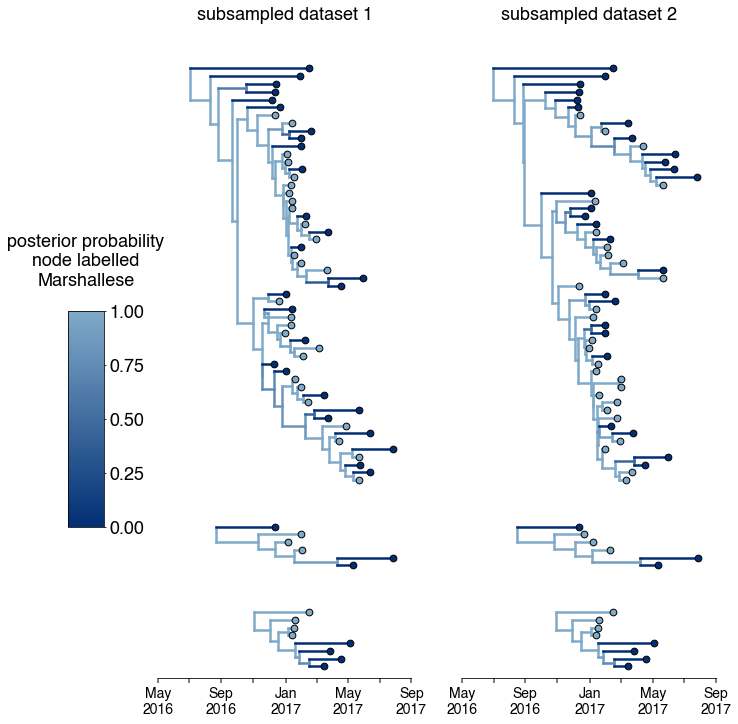

In [14]:
# read in files and run; this will generate multitype tree plots for each iteration and generate a dataframe that 
# can be used to look at and plot the distribution of posterior probabilities that a node is community, for each node 
# in each tree 
df = pd.DataFrame()
count = 0
axes_list = []
iterations_data_dict = {}

for f in glob.glob(directory + "*.mcc.tree"):
    
    clade = int(f.split("/")[-1].split("-")[10].replace(".typedNode.trees.mcc.tree",""))
    if clade == 69:
        list_location = 2
    elif clade == 10: 
        list_location = 1
    else:
        list_location = 0
    
    iteration = f.split("/")[-1].split("-")[8]
    if iteration not in iterations_data_dict:
        iterations_data_dict[iteration] = ["","",""]
    
    tree_path = f
    tree,filename = generate_tree_object(tree_path)
    metadata,node_types,node_probs = return_metadata_dictionaries(tree)
    
    df = generate_node_probs_df(node_probs, df, iteration)
    #plot_tree(tree, metadata, node_types, node_probs, filename)

    subtree_dict = {"tree":tree,"metadata":metadata,"node_types":node_types,"node_probs":node_probs,
            "filename":filename}
    iterations_data_dict[iteration][list_location] = subtree_dict
    
    #plot_tree(tree, metadata, node_types, node_probs, filename)
    
plot_mtt_subtrees_together(iterations_data_dict, 10,12) # width, height

# Plot the posterior probabilities of internal nodes

In [15]:
df.columns = ['node','pp_community','iteration']
df.head()

,node,pp_community,iteration
0,<baltic.node object at 0x7face2cc2908>,0.993154,3ac
1,<baltic.node object at 0x7face2cc2b38>,0.997436,3ac
2,<baltic.node object at 0x7face2cc29e8>,1.000000,3ac
3,<baltic.node object at 0x7face2cc2978>,1.000000,3ac
4,<baltic.node object at 0x7face2cc2a58>,1.000000,3ac


In [16]:
# row1 = df[df['iteration'].isin(["1","2","3","4","5"])]
# row1['row'] = '1'
# row2 = df[~df['iteration'].isin(["1","2","3","4","5"])]
# row2['row'] = '2'
# row3 = df[df['iteration'].isin(["11","12","13","14","15"])]
# row3['row'] = '3'
# row4 = df[~df['iteration'].isin(["11","12","13","14","15"])]
# row4['row'] = '4'

# df2 = row1.append(row2)
# df2 = df2.append(row3)
# df2 = df2.append(row4)
# df2.head()

In [17]:
def relabel_iterations(iteration):
    if iteration == "3ac":
        label = 'subsampled\ndataset 2'
    elif iteration == "2bc":
        label = 'subsampled\ndataset 1'
    return(label)

In [18]:
df['iteration2'] = df['iteration'].apply(relabel_iterations)
df.head()

,node,pp_community,iteration,iteration2
0,<baltic.node object at 0x7face2cc2908>,0.993154,3ac,subsampled\ndataset 2
1,<baltic.node object at 0x7face2cc2b38>,0.997436,3ac,subsampled\ndataset 2
2,<baltic.node object at 0x7face2cc29e8>,1.000000,3ac,subsampled\ndataset 2
3,<baltic.node object at 0x7face2cc2978>,1.000000,3ac,subsampled\ndataset 2
4,<baltic.node object at 0x7face2cc2a58>,1.000000,3ac,subsampled\ndataset 2


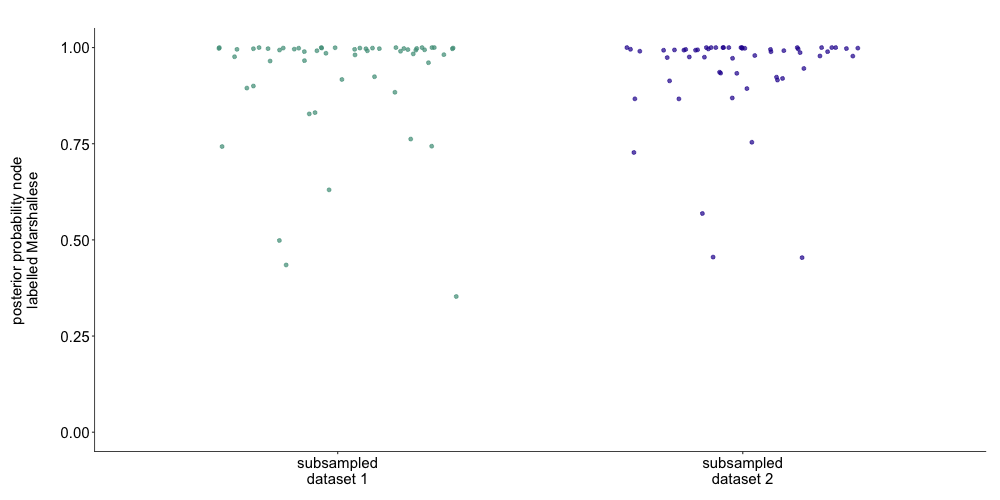

In [20]:
%%R -w 1000 -h 500 -u px -i df,figures_directory  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)
library(gridExtra)
library(grid)
library(RColorBrewer)
darkcols <- brewer.pal(10, "Dark2")

# df$iteration = as.numeric(df$iteration)
# df$color = as.character(df$iteration)
# df$node = as.character(df$node)

p <- ggplot(data=df, aes(x=iteration2, y=pp_community, color=iteration)) + 
    #facet_wrap(~iteration)+
    geom_jitter(width = 0.3, alpha=0.7)+
    #geom_vline(xintercept=vlines1, size=0.8, linetype='dashed', color = '#808080')+
    labs(x=NULL,y="posterior probability node\nlabelled Marshallese")+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_colour_manual(values=c("#4C9C86","#271B9C"), guide=FALSE)+
    #scale_x_continuous(limits=c(0.75,5.25), breaks=seq(1,5,1))+
    scale_y_continuous(limits=c(0,1))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=15))+
    theme(axis.title.y=element_text(size=15, vjust=8))+
    theme(axis.title.x=element_text(size=15))+
    theme(axis.text=element_text(size=15, colour="black"))+
    theme(legend.text=element_text(size=15))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1.0,0.5,0.5,1.0),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("node_pp_community-2020-09-15.pdf", p, width = 7, height = 4, path=figures_directory)
p

TableGrob (5 x 2) "arrange": 6 grobs
  z     cells    name                grob
1 1 (1-1,2-2) arrange      gtable[layout]
2 2 (2-2,2-2) arrange      gtable[layout]
3 3 (3-3,2-2) arrange      gtable[layout]
4 4 (4-4,2-2) arrange      gtable[layout]
5 5 (5-5,2-2) arrange text[GRID.text.315]
6 6 (1-5,1-1) arrange text[GRID.text.316]


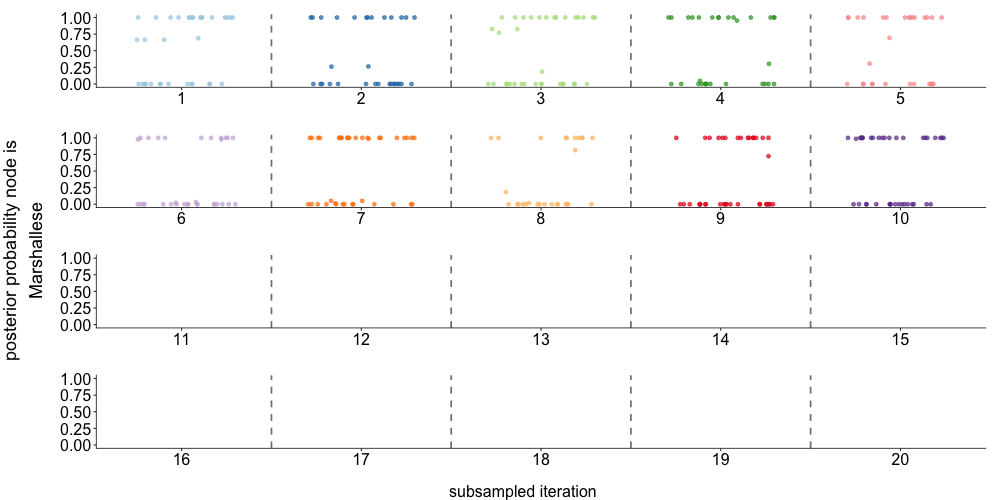

In [23]:
%%R -w 1000 -h 500 -u px -i df,directory  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)
library(gridExtra)
library(grid)
library(RColorBrewer)
darkcols <- brewer.pal(10, "Dark2")

df$iteration = as.numeric(df$iteration)
df$color = as.character(df$iteration)
df$node = as.character(df$node)

vlines = c(1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,11.5,12.5,13.5,14.5,15.5,16.5,17.5,18.5,19.5)
vlines1 = c(1.5,2.5,3.5,4.5)
vlines2 = c(6.5,7.5,8.5,9.5)
vlines3 = c(11.5,12.5,13.5,14.5)
vlines4 = c(16.5,17.5,18.5,19.5)

df1 <- subset(df, iteration <= 5)
df2 <- subset(df, iteration > 5 & iteration <= 10)
df3 <- subset(df, iteration > 10 & iteration <= 15)
df4 <- subset(df, iteration > 15)

p1 <- ggplot(data=df1, aes(x=iteration, y=pp_community, color=color)) + 
    geom_jitter(width = 0.3, alpha=0.7)+
    geom_vline(xintercept=vlines1, size=0.8, linetype='dashed', color = '#808080')+
    labs(x=NULL,y=NULL)+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_x_continuous(limits=c(0.75,5.25), breaks=seq(1,5,1))+
    scale_y_continuous(limits=c(0,1))+
    scale_colour_manual(values = (brewer.pal(10, "Paired")), guide=FALSE)+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=16))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(0.5,0.5,0.5,0.5),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

p2 <- ggplot(data=df2, aes(x=iteration, y=pp_community, color=color)) + 
    geom_jitter(width = 0.3, alpha=0.7)+
    geom_vline(xintercept=vlines2, size=0.8, linetype='dashed', color = '#808080')+
    labs(x=NULL,y=NULL)+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_x_continuous(limits=c(5.75,10.25), breaks=seq(6,10,1))+
    scale_y_continuous(limits=c(0,1))+
    scale_colour_manual(values = rev(brewer.pal(10, "Paired")), guide=FALSE)+
    #scale_fill_manual(values=c('#292166', '#8FD086'))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=16))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(0.5,0.5,0.5,0.5),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

p3 <- ggplot(data=df3, aes(x=iteration, y=pp_community, color=color)) + 
    geom_jitter(width = 0.3, alpha=0.7)+
    geom_vline(xintercept=vlines3, size=0.8, linetype='dashed', color = '#808080')+
    labs(x=NULL,y=NULL)+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_x_continuous(limits=c(10.75,15.25), breaks=seq(11,15,1))+
    scale_y_continuous(limits=c(0,1))+
    scale_colour_manual(values = (brewer.pal(10, "Paired")), guide=FALSE)+
    #scale_fill_manual(values=c('#292166', '#8FD086'))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=16))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(0.5,0.5,0.5,0.5),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

p4 <- ggplot(data=df4, aes(x=iteration, y=pp_community, color=color)) + 
    geom_jitter(width = 0.3, alpha=0.7)+
    geom_vline(xintercept=vlines4, size=0.8, linetype='dashed', color = '#808080')+
    labs(x=NULL,y=NULL)+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_x_continuous(limits=c(15.75,20.25), breaks=seq(16,20,1))+
    scale_y_continuous(limits=c(0,1))+
    scale_colour_manual(values = rev(brewer.pal(10, "Paired")), guide=FALSE)+
    #scale_fill_manual(values=c('#292166', '#8FD086'))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=16))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(0.5,0.5,0.5,0.5),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))


p = grid.arrange(p1,p2,p3,p4, nrow=4, left=textGrob("posterior probability node is\nMarshallese", gp=gpar(fontsize=18), rot=90), bottom=textGrob("subsampled iteration", gp=gpar(fontsize=16)))
ggsave("node_pp_community-2020-06-02.pdf", p, width = 9, height = 9, path=directory)
p

## Plot and perform statistics on mtt original and subsampled datasets

I generated 10 randomly subsampled datasets with equal numbers of community and non-community tips. I now need to read in all of those log file and plot their migration rates and Ne values. 

In [186]:
def read_in_log_files(directory):
    # read in log files
    log_files = []
    
    for f in glob.glob(directory + "*.log"):
        log_files.append(f)
    
    return(log_files)

In [211]:
def generate_dataframes_from_log_files(log_file,burnin_percent):
    log = pd.read_table(log_file, sep='\t', header='infer')

    # remove burnin; length of dataframe / 10, rounded up
    burnin = round(len(log) * burnin_percent)
    log_burnin_removed = log.iloc[burnin:]
    burnin = round(len(log) * burnin_percent)
    log_burnin_removed = log.iloc[burnin:]
    
    # in this model, Ne and migration rate have scale factors, while jump counts do not, which is why the selected columns differ
    Ne_cols = [col for col in log_burnin_removed.columns if '.popSize' in col][1:3]
    mig_cols = [col for col in log_burnin_removed.columns if '.rateMatrix' in col][1:3]
    mig_cols = [col for col in mig_cols if 'ScaleFactor' not in col]
    jump_cols = [col for col in log_burnin_removed.columns if '.count' in col][0:2]
    jump_cols = [col for col in jump_cols if 'to' in col]

    # subset to just Ne, migration rates, or jump counts
    Ne = log_burnin_removed[Ne_cols]
    mig_rates = log_burnin_removed[mig_cols]
    jump_counts = log_burnin_removed[jump_cols]
    
    # rename columns, and melt
    mig_rates.columns = ['marshallese_to_not','not_to_marshallese']
    mig_rates = pd.melt(mig_rates)

    jump_counts.columns = ['marshallese_to_not','not_to_marshallese']
    jump_counts = pd.melt(jump_counts)

    Ne.columns = ['Marshallese','Not_Marshallese']
    Ne = pd.melt(Ne)

    
    return(Ne,mig_rates,jump_counts)

In [212]:
def create_outfile_names(directory,subsampled):
    outfile_directory = directory
    date = (datetime.datetime.now()).strftime('%Y-%m-%d')
    
    if subsampled == True: 
        s = 'subsampled-iterations-'
    if subsampled == False:
        s = ''
    
    Ne_outfile_name = "Ne-mtt-" + s  + date + ".pdf"
    mig_outfile_name = "migration-rates-mtt-" + s + date + ".pdf"
    jumps_outfile_name = "jump-counts-" + s  + date + ".pdf"
    
    return(outfile_directory,Ne_outfile_name,mig_outfile_name,jumps_outfile_name)

In [213]:
def run_functions(directory, subsampled,burnin_percent):
    
    count = 0

    # generate log files list
    log_files = read_in_log_files(directory)

    # generate output file names 
    outfile_directory,Ne_outfile_name,mig_outfile_name,jumps_outfile_name = create_outfile_names(directory,subsampled)

    # generate dataframes and append together
    Ne_all = pd.DataFrame()
    mig_all = pd.DataFrame()
    jumps_all = pd.DataFrame()

    for l in log_files:
        count += 1
        Ne,mig_rates,jump_counts = generate_dataframes_from_log_files(l,burnin_percent)
        Ne['iteration'] = str(count)
        mig_rates['iteration'] = str(count)
        jump_counts['iteration'] = str(count)

        Ne_all = Ne_all.append(Ne)
        mig_all = mig_all.append(mig_rates)
        jumps_all = jumps_all.append(jump_counts)

    return(Ne_all,mig_all,jumps_all,outfile_directory,Ne_outfile_name,mig_outfile_name,jumps_outfile_name)

In [214]:
# run for subsampled datasets
subsampled = False
burnin_percent = 0  # I already removed burnin with log combiner
directory = "/Users/lmoncla/Documents/Mumps/beast/mtt/2020-04-02-hot-chain/nicola-priors-limit-50/"
#directory = "/Users/lmoncla/Documents/Mumps/beast/mtt/2019-05-22-skygrid-clade1/subsampled2/"
#directory = "/Users/lmoncla/Documents/Mumps/beast/mtt/2019-05-22-skygrid-clade2/subsampled2/"

Ne,mig,jumps,outfile_directory,Ne_outfile_name,mig_outfile_name,jumps_outfile_name = run_functions(directory, subsampled,burnin_percent)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


In [215]:
# run for subsampled datasets
subsampled = True
burnin_percent = 0
directory = "/Users/lmoncla/Documents/Mumps/beast/mtt/2020-04-02-hot-chain/nicola-priors-limit-50/subsampled/try2-2020-07-20/"
#directory = "/Users/lmoncla/Documents/Mumps/beast/mtt/2019-05-22-skygrid-clade1/subsampled2/"
#directory = "/Users/lmoncla/Documents/Mumps/beast/mtt/2019-05-22-skygrid-clade2/subsampled2/"

Ne_all,mig_all,jumps_all,sub_outfile_directory,Ne_all_outfile_name,mig_all_outfile_name,jumps_all_outfile_name = run_functions(directory, subsampled,burnin_percent)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


In [216]:
mig_all

,variable,value,iteration
0,marshallese_to_not,1.023827,1
1,marshallese_to_not,1.071296,1
2,marshallese_to_not,0.957913,1
3,marshallese_to_not,0.848661,1
4,marshallese_to_not,1.027214,1
5,marshallese_to_not,0.544496,1
6,marshallese_to_not,0.480741,1
7,marshallese_to_not,0.295675,1
8,marshallese_to_not,1.118801,1
9,marshallese_to_not,1.148329,1


## Try plotting them together now 

In [217]:
Not_Marshallese_color = '#012E74'
Marshallese_color = '#80AAC9'

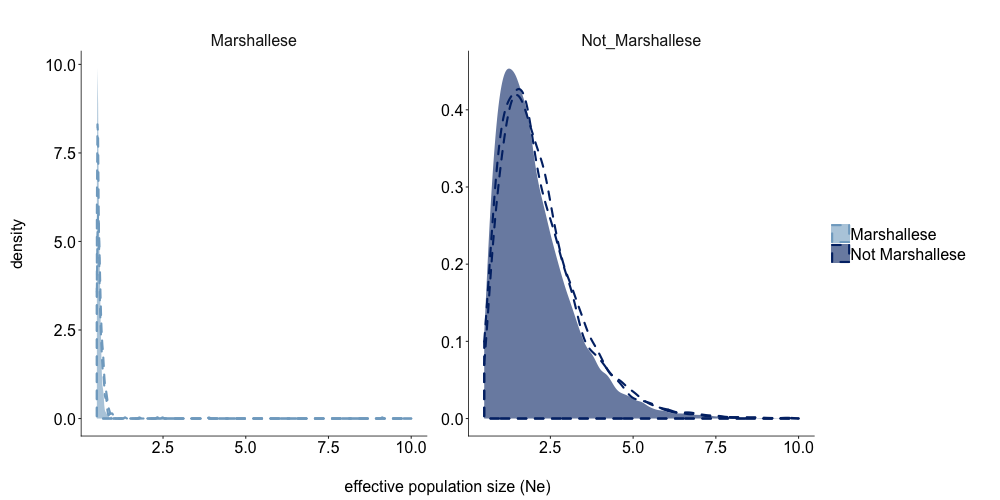

In [218]:
%%R -w 1000 -h 500 -u px -i Ne,Ne_all,sub_outfile_directory,Ne_all_outfile_name,Marshallese_color,Not_Marshallese_color  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

p <- ggplot(data=NULL, aes(x=value, group=iteration, color=variable, fill=variable)) + 
    geom_density(data=Ne, alpha=0.60, linetype="blank")+
    geom_density(data=Ne_all, alpha=0.001, linetype="dashed",size=1)+
    #geom_line(data=dat, x=dat$x, y=dat$px, color="black")+
    facet_wrap(~variable, scales='free')+
    labs(x="effective population size (Ne)",y="density")+
    #ggtitle("Re estimates") + 
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_x_continuous(limits=c(0.5,10))+ 
    #scale_y_continuous(limits=c(0,10))+
    scale_color_manual(values=c(Marshallese=Marshallese_color, Not_Marshallese=Not_Marshallese_color,"#808080"), labels=c("Marshallese","Not Marshallese","prior"))+
    scale_fill_manual(values=c(Marshallese=Marshallese_color, Not_Marshallese=Not_Marshallese_color,"#808080"), labels=c("Marshallese","Not Marshallese","prior"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=16))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave(Ne_all_outfile_name, p, width = 12, height = 4,path=sub_outfile_directory)
p

In [219]:
outfile_directory = "/Users/lmoncla/Documents/Mumps/paper-and-figure-drafts/individual-PDFs"

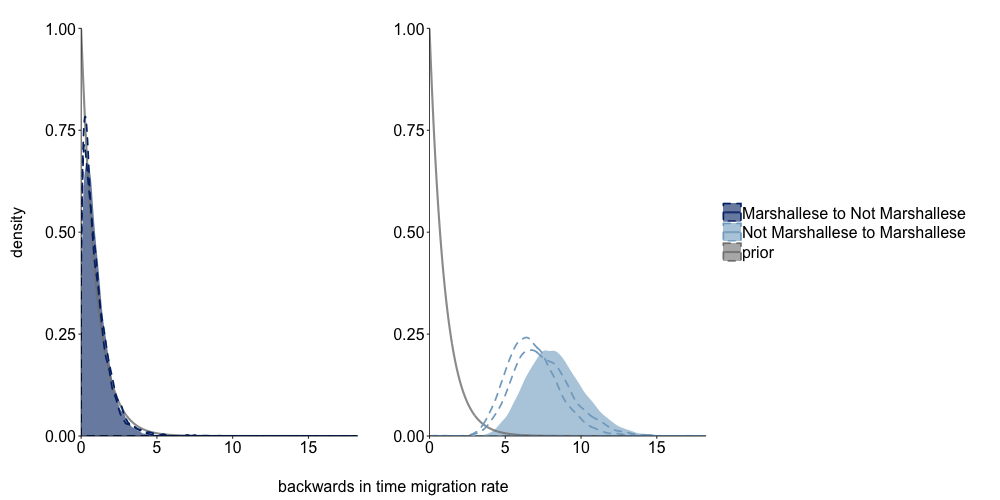

In [222]:
%%R -w 1000 -h 500 -u px -i mig,mig_all,outfile_directory,mig_all_outfile_name,Marshallese_color,Not_Marshallese_color  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

x <- seq(0, 15, length.out=1000)
dat <- data.frame(value=x, y=dexp(x, rate=1.0))
dat$iteration = 'prior'

blank_data <- data.frame(x=0, y=c(0, 0.25, 0, 2.5), group=c("marshallese_to_not","marshallese_to_not","not_to_marshallese","not_to_marshallese"),color="prior",fill="prior")

p <- ggplot(data=NULL) + 
    geom_density(data=mig, aes(x=value, group=iteration, color=variable, fill=variable), alpha=0.60, linetype="blank")+
    geom_line(data=dat, aes(x=value, y=y, group=iteration, color="prior", fill="prior"), linetype="solid", size=1, alpha=0.8)+
    geom_density(data=mig_all, aes(x=value, group=iteration, color=variable, fill=variable), alpha=0.001, linetype="dashed",size=0.8)+
    geom_blank(data = blank_data, aes(x = x, y = y))+
    facet_wrap(~variable, scales='free_y')+
    labs(x="backwards in time migration rate",y="density")+
    #ggtitle("Re estimates") + 
    scale_color_manual(values=c(marshallese_to_not = Not_Marshallese_color,not_to_marshallese=Marshallese_color, prior="#808080"), labels=c("Marshallese to Not Marshallese","Not Marshallese to Marshallese","prior"))+
    scale_fill_manual(values=c(marshallese_to_not = Not_Marshallese_color,not_to_marshallese=Marshallese_color, prior="#808080"), labels=c("Marshallese to Not Marshallese","Not Marshallese to Marshallese","prior"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_blank())+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(panel.spacing.x=unit(2.5, "lines"))+    # increase space between facets
    theme(legend.key=element_rect(fill=NA)) +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0), limits=c(0,1.0))

ggsave(mig_all_outfile_name, p, width = 12, height = 4,path=outfile_directory)
p